In [75]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("/usr/wrk/people9/sima9999/code/")
# sys.path.append("/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/code/")
import numpy as np
import zlib, zipfile
import pyansys
from model.mechanical import Mechanical, MechanicalDummy
sys.path.append('/home/sima9999/git/PolyUQ/')
from polymorphic_uncertainty import MassFunction, RandomVariable, PolyUQ, \
stat_fun_avg, stat_fun_cdf, stat_fun_ci, stat_fun_hist, stat_fun_lci, stat_fun_pdf, generate_histogram_bins, aggregate_mass
import logging
import psutil
import time

# a bug in jupyter / ipympl / matplotlib needs this here when using %maptlotlib widget
# somehow rc_context is broken in that case
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.WARNING)

logger_mech=logging.getLogger('model.mechanical')
logger_mech.setLevel(level=logging.WARNING)

global ansys

from examples.UQ_Modal_Beam import *

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc -ray

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import matplotlib
import matplotlib.pyplot as plt
np.set_printoptions(precision=6)#precision=2)

from helpers import get_pcd 
print_context_dict = get_pcd('print')

global ansys
try:
    print(ansys)
except:
    ansys=None

In [4]:
mech = Mechanical(ansys, wdir='/run/user/30980/')
ansys=mech.ansys
ansys.clear()

In [59]:
plt.close('all')
n_nodes=3
if True:
    mech.example_rod(n_nodes, damping=(4.976,4.308e-4,True), num_modes=n_nodes-1)
    fmax=50
else:
    mech.example_beam(n_nodes,damping=0.01, damp_mode=1, num_modes=n_nodes-1)
    fmax = 1
freq, damp, _ = mech.modal()

in_node = n_nodes
in_dof = 'uz'
in_dof_ind = Mechanical.dofs_str_to_ind([in_dof])[0]

out_node = in_node
out_dof = in_dof
out_dof_ind = Mechanical.dofs_str_to_ind([out_dof])[0]

out_quant = 'd'
# print(mech.modal(damped=False, use_cache=False)[0])
# print(mech.modal(damped=True, use_cache=False)[0])

72029999.99999999 0
1103500.0 6651.0


In [60]:
omegas, frf_cl = mech.frequency_response(65536, in_node, in_dof, out_quant=out_quant, fmax=fmax)
omegas, frf_nc, dof_ref = mech.frequency_response_non_classical(65536, in_node, in_dof, True, in_dof, fmax=fmax, out_quant=out_quant)
omegas = omegas[:,0]

In [61]:
import scipy.sparse
import scipy.sparse.linalg
full_path = '/run/user/30980/file.full'
full = pyansys.read_binary(full_path)
# # TODO: Check, that Nodes and DOFS are in the same order in modeshapes and k,m


if False:
    dof_ref_, k, m, c = full.load_kmc(as_sparse=True, sort=False)
    k += scipy.sparse.triu(k, 1).T
    m += scipy.sparse.triu(m, 1).T
    c += scipy.sparse.triu(c, 1).T
    del full

    mask1=k.getnnz(1)>0
    mask2=k.getnnz(0)>0

    k_ = k[mask1][:,mask2]
    m_ = m[mask1][:,mask2]
    c_ = c[mask1][:,mask2]

    dof_ref_ = dof_ref_[mask1,:]
else:
    dof_ref_, k, m, c = full.load_kmc(as_sparse=False, sort=False)
    k += np.triu(k, 1).T
    m += np.triu(m, 1).T
    c += np.triu(c, 1).T
    
    mask1 = ~np.all(k==0, axis=1)
    mask2= ~np.all(k==0, axis=0)
    dof_ref_ = dof_ref_[mask1,:]
    k_ = k[mask2,:]
    m_ = m[mask2,:]
    c_ = c[mask2,:]
    k_ = k_[:,mask1]
    m_ = m_[:,mask1]
    c_ = c_[:,mask1]

In [62]:
all_z_inv_l=[]
then = time.time()
for omega in omegas:
    z = k_ + 1j*omega*c_ - omega**2*m_
    if isinstance(z, scipy.sparse.spmatrix):
        z = z.todense()
    z_inv = np.linalg.inv(z)
    all_z_inv_l.append(z_inv)
    now=time.time()
    then=now
all_z_inv = np.array(all_z_inv_l)

In [63]:
in_ind_z = np.logical_and(dof_ref_[:,0] == in_node, dof_ref_[:,1] == in_dof_ind)
out_ind_z = np.logical_and(dof_ref_[:,0] == out_node, dof_ref_[:,1] == out_dof_ind)
out_ind = mech.meas_nodes == out_node
frfz = np.squeeze(all_z_inv[:, in_ind_z, out_ind_z])
frfnc = np.squeeze(frf_nc[:, out_ind]) # choose output node
frfcl = np.squeeze(frf_cl[:, out_ind]) # choose output node

In [64]:
if out_quant == 'a':
    frfz *=   -omegas**2
elif out_quant == 'v':
    frfz *= 1j*omegas
elif out_quant == 'd':
    ...
else:
    logger.warning(f'This output quantity is invalid: {out_quant}')

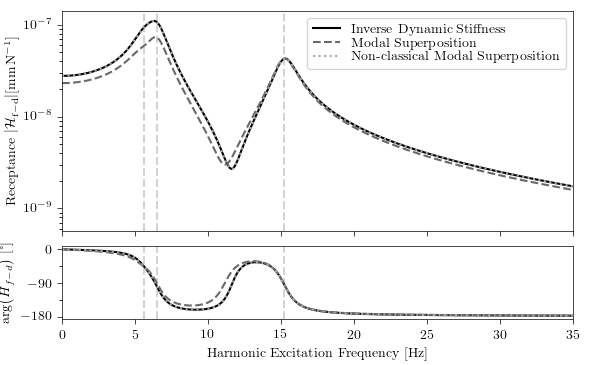

In [103]:
with matplotlib.rc_context(get_pcd('print')):
    fig,[ax1,ax2]=plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, sharex=True)

    for f in freq:
        ax1.axvline(f, c='lightgrey', ls='dashed')
        ax2.axvline(f, c='lightgrey', ls='dashed')
    # else:
    #     ax1.axvline(f, c='lightgrey', ls='dashed', label='Natural Frequencies')
    ax1.plot(omegas/2/np.pi, np.abs(frfz), color='k', label="Inverse Dynamic Stiffness", ls='solid')
    ax2.plot(omegas/2/np.pi, np.angle(frfz)/np.pi*180, color='k', ls='solid')
    ax1.plot(omegas/2/np.pi, np.abs(frfcl), color='dimgrey', label='Modal Superposition', ls='dashed')
    ax2.plot(omegas/2/np.pi,np.angle(frfcl)/np.pi*180, color='dimgrey', ls='dashed')
    ax1.plot(omegas/2/np.pi, np.abs(frfnc), color='darkgrey', label='Non-classical Modal Superposition', ls='dotted')
    ax2.plot(omegas/2/np.pi, np.angle(frfnc)/np.pi*180, color='darkgrey', ls='dotted')
    ax1.set_yscale('log')
    ax1.set_xlim((0,35))
    ax1.legend(loc='upper right')
    ax1.set_ylabel('Receptance $|\mathcal{H}_\mathrm{f-d}| [\si{\milli\meter\per\\newton}]$')
    ax2.set_ylabel('$\\arg\\bigl(H_{f-d}\\bigr)$ [\si{\degree}]')
    ax2.set_xlabel('Harmonic Excitation Frequency [\si{\hertz}]')

    ax2.yaxis.set_major_locator(plt.MultipleLocator(90))
    ax2.yaxis.set_minor_locator(plt.MultipleLocator(45))
    fig.subplots_adjust(top=0.97,bottom=0.125, left=0.105, right=0.97, hspace=0.1)
    plt.savefig('/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/modeling_realization/frf_non-classical_rod.pdf')
    plt.savefig('/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/modeling_realization/frf_non-classical_rod.png')
    plt.show()

In [30]:
frfs_cl = []
for mode in range(3):
    omegas, frf_cl = mech.frequency_response(65536, in_node, in_dof, out_quant=out_quant, fmax=fmax, modes=[mode])
    frfs_cl.append(frf_cl)
omegas = omegas[:,0]

In [31]:
frfs_nc = []
for mode in range(3):
    omegas, frf_nc, dof_ref = mech.frequency_response_non_classical(65536, in_node, in_dof, True, in_dof, fmax=fmax, out_quant=out_quant, modes=[mode])
    frfs_nc.append(frf_nc)
omegas = omegas[:,0]

In [32]:
for mode in range(3):
    frf_nc = frfs_nc[mode]
    frf_cl = frfs_cl[mode]
    frfnc = np.squeeze(frf_nc[:, out_ind]) # choose output node
    frfcl = np.squeeze(frf_cl[:, out_ind]) # choose output node
    ax1.plot(omegas/2/np.pi, np.abs(frfnc), color='lightgrey', ls='dotted')
    ax2.plot(omegas/2/np.pi, np.angle(frfnc)/np.pi*180, color='lightgrey', ls='dotted')
    ax1.plot(omegas/2/np.pi, np.abs(frfcl), color='dimgrey', ls='dotted')
    ax2.plot(omegas/2/np.pi,np.angle(frfcl)/np.pi*180, color='dimgrey', ls='dotted')

In [13]:
ks, ms, cs = mech.export_ans_mats()

array([ 5.60881 ,  6.508912, 15.230017])

array([0.150691, 0.108885, 0.04839 ])

array([ 5.60881 ,  6.508912, 15.230017])

array([0.150691, 0.108885, 0.04839 ])

array([ 5.60881 ,  6.508912, 15.230017])

array([0.150691, 0.108885, 0.04839 ])

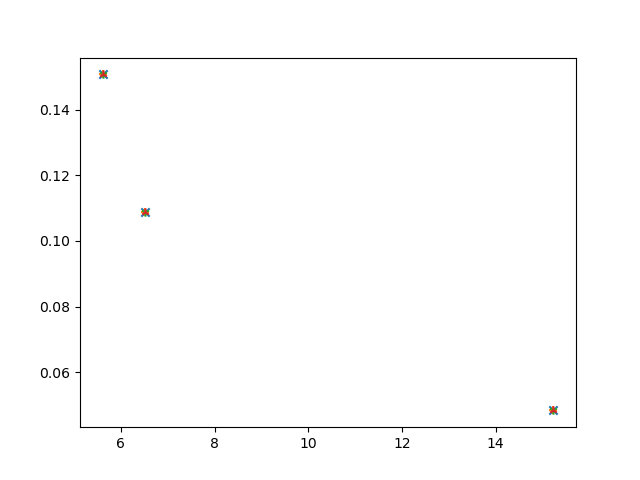

In [14]:
import scipy
plt.figure()
o = np.zeros_like(k_)
B = np.vstack([np.hstack([k_,o]),
               np.hstack([o,-m_])])
A = np.vstack([np.hstack([o,k_]),
               np.hstack([k_,-c_])])
w,v = scipy.linalg.eig(A,-B)
f = np.imag(w)/2/np.pi
zeta = -np.real(w)/np.abs(w)
ind = np.argsort(f)
f = f[ind]
zeta = zeta[ind]
display(f[f>0][:14])
display(zeta[f>0][:14])
plt.scatter(f[f>0][:14],zeta[f>0][:14], label='full 1', marker='x')

B = np.vstack([np.hstack([c_,-m_]),np.hstack([-m_,o])])
A= np.vstack([np.hstack([k_,o]),np.hstack([o,-m_])])
w = scipy.linalg.eigvals(A,-B)
f = np.imag(w)/2/np.pi
zeta = -np.real(w)/np.abs(w)
ind = np.argsort(f)
f = f[ind]
zeta = zeta[ind]
display(f[f>0][:14])
display(zeta[f>0][:14])
plt.scatter(f[f>0][:14],zeta[f>0][:14], label='full 2', marker='+')

# this method somehow yields results, that are slightly off, so I suppose they can not be trusted
# 
os = np.zeros_like(ks)
B = np.vstack([np.hstack([cs,-ms]),
               np.hstack([-ms,os])])
A = np.vstack([np.hstack([ks,os]),
               np.hstack([os,-ms])])
w = scipy.linalg.eigvals(A,-B)
f = np.imag(w)/2/np.pi
zeta = -np.real(w)/np.abs(w)
ind = np.argsort(f)
f = f[ind]
zeta = zeta[ind]
display(f[f>0][:14])
display(zeta[f>0][:14])
plt.scatter(f[f>0][:14],zeta[f>0][:14], label='export', marker='1')

plt.scatter(freq, damp, label='ansys', marker='2') 

In [125]:
# k_,c_,m_ = ks,cs,ms
num_modes = 14
o = np.zeros_like(k_)
B = np.vstack([np.hstack([k_,o]),
               np.hstack([o,-m_])])
A = np.vstack([np.hstack([o,k_]),
               np.hstack([k_,-c_])])
# A = np.vstack([np.hstack([o,k_]),
#                np.hstack([k_,o])])
w,v = scipy.linalg.eig(A,-B)

f = np.imag(w)/2/np.pi
zeta = -np.real(w)/np.abs(w)

ind = np.argsort(f)
f = f[ind]
ind2 = (f > 0)
f = (f[ind2])[:num_modes]
zeta = (zeta[ind][ind2])[:num_modes]

v = (v[k_.shape[0]:, ind][:, ind2])[:,:num_modes]

mu = np.diag(v.T @ m_ @ np.conj(v))
display(v)
for mode in range(len(mu)):
    v[:, mode] /= np.sqrt(mu[mode])
    
display(f[:14])
display(zeta[:14])
display(mu[:14])
np.set_printoptions(precision=3)
display(v*1000)

array([[-0.028-0.062j, -0.193-0.011j,  0.565-0.01j ],
       [-0.047-0.093j, -0.266-0.006j, -0.809+0.008j],
       [-0.89 -0.437j,  0.639+0.695j,  0.134+0.094j]])

array([ 5.609,  6.509, 15.23 ])

array([0.151, 0.109, 0.048])

array([ 1057.113+0.000e+00j,  2676.234+0.000e+00j, 17419.828-2.842e-14j])

array([[ -0.855 -1.903j,  -3.739 -0.216j,   4.28  -0.078j],
       [ -1.444 -2.861j,  -5.14  -0.11j ,  -6.126 +0.059j],
       [-27.385-13.44j ,  12.343+13.44j ,   1.014 +0.715j]])

In [116]:
this_k = k_
this_m = m_
w,v = scipy.linalg.eig(this_k, this_m)
mu = np.diag(v.T @ this_m @ v)
# display(mu)
for mode in range(len(mu)):
    v[:, mode] /= np.sqrt(mu[mode])
kappa =  np.diag(v.T @ this_k @ v)
mu = np.diag(v.T @ this_m @ v)
display(kappa[:14],mu[:14], np.sqrt(w)[:14]/2/np.pi)
np.set_printoptions(precision=2)
display(v[0,0])

array([9182.100896, 1754.068078, 1225.809877])

array([1., 1., 1.])

array([15.250749+0.j,  6.665663+0.j,  5.572264+0.j])

0.004279699394889907

In [145]:
num_modes=14
if isinstance(k_, scipy.sparse.spmatrix):
    o = scipy.sparse.csc_matrix(k_.shape)
    A = scipy.sparse.vstack([scipy.sparse.hstack([ o,  m_]),
                   scipy.sparse.hstack([ m_, c_])])
    B = scipy.sparse.vstack([scipy.sparse.hstack([-m_, o ]),
                   scipy.sparse.hstack([ o,  k_])])
    w,v = scipy.sparse.linalg.eigs(-B, num_modes, A,which='SI', sigma=1000j, OPpart='i')
else:
    o = np.zeros_like(k_)
    A = np.vstack([np.hstack([ o,  m_]),
                   np.hstack([ m_, c_])])
    B = np.vstack([np.hstack([-m_, o ]),
                   np.hstack([ o,  k_])])
    w,v = scipy.linalg.eig(-B,A)
mus = v[v.shape[0]//2:,:].T @ m_ @ np.conj(v[v.shape[0]//2:,:])
np.set_printoptions(precision=2)
display(w,v)
f = np.imag(w)/2/np.pi
zeta = -np.real(w)/np.abs(w)
np.set_printoptions()
ind = np.argsort(f)
f = f[ind]
ind2 = (f > 0)
f = f[ind2][:num_modes]
zeta = zeta[ind][ind2][:num_modes]
phi = v[n_nodes:, ind][:, ind2][:,:num_modes]
mus = np.diag(mus)[ind][ind2][:num_modes]
display(f*2*np.pi, zeta)
np.set_printoptions(precision=4)
display(mus)
for mode in range(len(mu)):
    # pass
    phi[:, mode] /= np.sqrt(mus[mode])
display(phi*1e2)    

array([-4.64+95.69j, -4.64-95.69j, -4.48+40.9j , -4.48-40.9j ,
       -5.37+35.24j, -5.37-35.24j])

array([[-5.63e-01-5.24e-02j, -5.63e-01+5.24e-02j, -1.91e-01-3.40e-02j,
        -1.91e-01+3.40e-02j, -1.68e-02-6.57e-02j, -1.68e-02+6.57e-02j],
       [ 8.04e-01+8.19e-02j,  8.04e-01-8.19e-02j, -2.63e-01-3.72e-02j,
        -2.63e-01+3.72e-02j, -3.03e-02-9.97e-02j, -3.03e-02+9.97e-02j],
       [-1.23e-01-1.09e-01j, -1.23e-01+1.09e-01j,  5.52e-01+7.66e-01j,
         5.52e-01-7.66e-01j, -8.02e-01-5.83e-01j, -8.02e-01+5.83e-01j],
       [-2.63e-04+5.89e-03j, -2.63e-04-5.89e-03j, -3.17e-04+4.70e-03j,
        -3.17e-04-4.70e-03j, -1.75e-03+7.44e-04j, -1.75e-03-7.44e-04j],
       [ 4.48e-04-8.43e-03j,  4.48e-04+8.43e-03j, -2.01e-04+6.46e-03j,
        -2.01e-04-6.46e-03j, -2.64e-03+1.26e-03j, -2.64e-03-1.26e-03j],
       [-1.07e-03+1.33e-03j, -1.07e-03-1.33e-03j,  1.70e-02-1.54e-02j,
         1.70e-02+1.54e-02j, -1.28e-02+2.47e-02j, -1.28e-02-2.47e-02j]])

array([35.24, 40.9 , 95.69])

array([0.15, 0.11, 0.05])

array([0.8318-5.5511e-17j, 1.5811-1.2875e-18j, 1.8979-9.1025e-20j])

array([[-0.1921+0.0816j, -0.0252+0.3737j, -0.0191+0.4277j],
       [-0.2891+0.1384j, -0.016 +0.5139j,  0.0325-0.6118j],
       [-1.4005+2.7101j,  1.3557-1.2214j, -0.0777+0.0967j]])

In [18]:
(-2.63e-04+5.89e-03j)*(-4.64+95.69j)

(-0.56239378-0.05249607j)

In [19]:
np.set_printoptions(formatter={'all':lambda x: f'{x:1.4g}'})
display(k_)
display(c_)
np.set_printoptions(formatter={'all':lambda x: f'{x:5.3f}'})
display(m_)
np.set_printoptions(formatter={'all':lambda x: f'{x:1.4g}'})
display(B)
display(A)

array([[1.441e+08, -7.203e+07, 0],
       [-7.203e+07, 7.313e+07, -1.104e+06],
       [0, -1.104e+06, 1.104e+06]])

array([[1.96e+05, -3.103e+04, 0],
       [-3.103e+04, 1.051e+05, -7126],
       [0, -7126, 1.111e+04]])

array([[26925.500, 0.000, 0.000],
       [0.000, 13462.750, 0.000],
       [0.000, 0.000, 800.000]])

array([[-2.693e+04, -0, -0, 0, 0, 0],
       [-0, -1.346e+04, -0, 0, 0, 0],
       [-0, -0, -800, 0, 0, 0],
       [0, 0, 0, 1.441e+08, -7.203e+07, 0],
       [0, 0, 0, -7.203e+07, 7.313e+07, -1.104e+06],
       [0, 0, 0, 0, -1.104e+06, 1.104e+06]])

array([[0, 0, 0, 2.693e+04, 0, 0],
       [0, 0, 0, 0, 1.346e+04, 0],
       [0, 0, 0, 0, 0, 800],
       [2.693e+04, 0, 0, 1.96e+05, -3.103e+04, 0],
       [0, 1.346e+04, 0, -3.103e+04, 1.051e+05, -7126],
       [0, 0, 800, 0, -7126, 1.111e+04]])

In [20]:
ind4 = np.logical_and(dof_ref_[:,0] == in_node, dof_ref_[:,1] == 2)
ind3 = np.logical_and(dof_ref_[:,0] == out_node, dof_ref_[:,1] == 2)

#### Obtaining structural matrices in user ordering from MAPDL

Matrices in Full Files are in internal ordering
and should not be changed in their order or whatever, to avoid errors related to this operation
the usr2solv or nod2solv permutation operators can not be exported
so the only thing that is possible is to extract the nodal equivalence table from the full file
for this the load_km function in pyansys must be extended for the D/C matrix
!!!That is the only option!!!



#### Computing transfer functions with non-proportional damping matrices
the method in Kausel Eq. 3.574 P. 223 works directly on the structural matrices, but involves a matrix inverse for each frequency line, which is painfully slow
the modal approach is not valid, because the modal damping ratios obtained from the quadratic eigenvalue problem are just approximations
they are the nonclassical modal frequencies, damping and damped frequencies
what are the implications of nonclassical now?
Veletsos and Ventura 1986 show (?) that nonclassical modal parameters can be used to construct an impulse response function <-> frequency response function (Fourier pair)
TODO:
- check for any constraints on generality mentioned in the text 
- check that thy use the same procedure for solving the quadratic eigenvalue problem
- check that they use the same equations for the IRF
- would we have to use both pairs of complex conjugate modes? Are we doing that already? 



In [24]:
mech.modal(modal_matrices=True)
...

(array([5.609, 6.509, 15.23]),
 array([0.1507, 0.1089, 0.04839]),
 array([[[0+0j, 0+0j, 0+0j],
         [0+0j, 0+0j, 0+0j],
         [0+0j, 0+0j, 0+0j]],
 
        [[0+0j, 0+0j, 0+0j],
         [0+0j, 0+0j, 0+0j],
         [0.001812+0.001035j, -0.003679+0.0007024j, -0.004281+2.127e-05j]],
 
        [[0+0j, 0+0j, 0+0j],
         [0+0j, 0+0j, 0+0j],
         [0.002851+0.001463j, -0.005012+0.001147j, 0.006126+2.205e-05j]],
 
        [[0+0j, 0+0j, 0+0j],
         [0+0j, 0+0j, 0+0j],
         [0.03005-0.005257j, 0.01525+0.01002j, -0.001005-0.0007282j]]]),
 array([1271, 1693, 9179]),
 array([1, 1, 1]),
 array([10.74, 8.959, 9.272]),
 array([2.977+57j, 3.768+66.14j, 0.01409+191.3j]))